# Homework: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.



In [1]:
%tensorflow_version 2.x
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, Bidirectional
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

random.seed(42)

# Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [2]:
!wget https://www.dropbox.com/s/eexden7246sgfzf/BEST-TrainingSet.zip
!wget https://www.dropbox.com/s/n87fiy25f2yc3gt/wiki.zip
!unzip wiki.zip
!unzip BEST-TrainingSet.zip

--2021-02-20 07:46:27--  https://www.dropbox.com/s/eexden7246sgfzf/BEST-TrainingSet.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/eexden7246sgfzf/BEST-TrainingSet.zip [following]
--2021-02-20 07:46:28--  https://www.dropbox.com/s/raw/eexden7246sgfzf/BEST-TrainingSet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d7b30475c05b7543ced08f999.dl.dropboxusercontent.com/cd/0/inline/BJT-y5GgEe88U4azyY93HCiFL0lELmNqmFq9Bj4LRoY8ec2kmpqoEmOU3b1rt7BB-cXq42dPFBH628XPjFgSpbDAiX4hUxAexQ3ysA8OIK9u6v_jfSBZApuBeC4fctGO-No/file# [following]
--2021-02-20 07:46:28--  https://uc8d7b30475c05b7543ced08f999.dl.dropboxusercontent.com/cd/0/inline/BJT-y5GgEe88U4azyY93HCiFL0lELmNqmFq9Bj4LRoY8ec2kmpqoEmOU3b1rt7BB-cXq42dPFBH628XPjFgSpbD

In [3]:
#Step 1: read the wikipedia text file
with open("wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [4]:
tokens = input_text
print(tokens[:10])
print("total word count:", len(tokens))

['หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']
total word count: 36349066


# Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='blue'>Homework Question 1:</font>
<font color='blue'>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='blue'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

In [5]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text, min_thres_unk = 0, max_word_count = None):
    # TODO#1 : edit or replace this function
    words = [word for word in input_text ]
    word_count = list()

    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))

    #min threshold
    word_count = [(word[0], word[1]) for word in word_count if word[1] > min_thres_unk]
    
    #include a token for unknown word
    word_count.append(("UNK",0))
    #print out 10 most frequent words
    print(word_count[:10])
    print(len(word_count))
    print(word_count[(len(word_count)-10):])

    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
        # print(word)
        # print(dictionary[word])
        # # if word in word_count:
        try:
          data.append(dictionary[word])
        except:
          ###### the word is not in dict. add to UNK
          data.append(dictionary['UNK'])
          # pass


    return data, dictionary, reverse_dictionary

# call method with min_thres_unk=1ß
dataset, dictionary, reverse_dictionary = create_index(tokens, 1)
print(len(dataset))
print(len(dictionary))

[('ที่', 950006), ('ใน', 897329), ('เป็น', 726847), ('และ', 668116), ('การ', 619128), ('มี', 536738), ('ของ', 532237), ('ได้', 508117), (')', 359576), ('"', 357830)]
295164
[('ฟรืส', 2), ('นิมิตตวิโมกข์', 2), ('วิโมกฺข', 2), ('อนุโลมญาน', 2), ('หรือวีเจ', 2), ('แก๊งเฟี้ยว', 2), ('เมฟลึท', 2), ('แมร์ท', 2), ('เพาล์ดำรง', 2), ('UNK', 0)]
36349066
295164


In [6]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24]
output sample (dictionary): {'for_keras_zero_padding': 0, 'ที่': 1, 'ใน': 2, 'เป็น': 3, 'และ': 4, 'การ': 5, 'มี': 6, 'ของ': 7, 'ได้': 8, ')': 9}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ที่', 2: 'ใน', 3: 'เป็น', 4: 'และ', 5: 'การ', 6: 'มี', 7: 'ของ', 8: 'ได้', 9: ')'}


# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='blue'>Homework Question 2:</font>
<font color='blue'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



<font color='red'>Q2: The different between Technique tought in class and Keras source code is the probability of the negative sampling<br>
<u>Technique tought in class</u> : use actual probability of that word in our data set and power 3/4 to increases probability of the rare word to be negative sampling<br>
<u>Keras source code</u> : use probability based in rank on the word in our data set be below formula<br>
frequency(rank) ~ 1/(rank * (log(rank) + gamma) + 1/2 - 1/(12*rank))<br>
where gamma = Euler-Mascheroni constant (~0.57721)
<br></font>



In [7]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

# TODO#2 check out keras source code and find out how their sampling technique works. Describe it in your own words.
sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]], labels[i])

[[208, 83708], [208, 2453], [2453, 573], [208, 235515], [24, 681], [2453, 208], [3124, 145853], [2453, 115575], [24, 3408], [208, 229], [3124, 681], [3124, 7149], [3124, 285707], [2453, 219950]] [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
หลัก Merlin 0
หลัก วิกิพีเดีย 1
วิกิพีเดีย ดำเนินการ 1
หลัก LaVoie 0
ไม่ องค์กร 1
วิกิพีเดีย หลัก 1
มีเดีย -House 0
วิกิพีเดีย (หงส์ทอง 0


In [8]:
sample_set

[229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24]

In [9]:
len(sampling_table)

295164

In [10]:
sampling_table[:10]

array([0.00315225, 0.00315225, 0.00547597, 0.00741556, 0.00912817,
       0.01068435, 0.01212381, 0.01347162, 0.01474487, 0.0159558 ])

# Step 4: create the skip-gram model
## <font color='blue'>Homework Question 3:</font>
 <font color='blue'>Q3:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

<font color='red'>Q3: To bound / normalize objective function within 0 and 1 and still smoothly reflect probability of the model between 0 and 1</font>

In [11]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V+1, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V+1, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        9445280     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        9445280     input_2[0][0]                    
______________________________________________________________________________________________

In [12]:
# # you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
# # currently the dataset is 1/20 of the full text file.
# percent_data = 0.02
# for k in range(5):
#     prev_i=0
#     #it is likely that your GPU won't be able to handle large input
#     #just do it 100000 words at a time
#     print("Start " + str(k+1) + " Ephoch")
#     for i in range(int(len(dataset)*percent_data)//100000):
#         #generate skipgrams
#         data, labels = skipgrams(sequence=dataset[prev_i*100000:(i*100000)+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
#         x = [np.array(x) for x in zip(*data)]
#         y = np.array(labels, dtype=np.int32)
#         if x:
#             loss = SkipGram.train_on_batch(x, y)
#         prev_i = i 
#         print(loss,i*100000)
#     print("Complete " + str(k+1) + " Ephoch")

# print("Completed")

In [13]:
# SkipGram.save_weights('my_skipgram32_weights-hw.h5')

In [45]:
#Get weight of the embedding layer
SkipGram.load_weights('my_skipgram32_weights-hw.h5')
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)
print(final_embeddings.shape)

[[ 0.04070104 -0.02753905  0.04670351 ... -0.00551665  0.03392745
   0.00921159]
 [ 0.5919084   0.6860344  -0.5775944  ... -0.55672723 -0.71534324
   0.62468827]
 [ 0.6063158   0.61661875 -0.544324   ... -0.6264903  -0.7115695
   0.6156043 ]
 ...
 [ 0.04438089 -0.02127985  0.01342139 ...  0.01969821  0.0454649
   0.0443229 ]
 [ 0.01121974  0.02433923 -0.03438437 ... -0.03812686 -0.0373131
  -0.01421703]
 [-0.00633546  0.04996828  0.00219416 ...  0.04321237 -0.04536206
   0.03131013]]
(295165, 32)


# Step 5: Intrinsic Evaluation: Word Vector Analogies
## <font color='blue'>Homework Question 4: </font>
<font color='blue'> Read section 2.1 and 2.3 in this [lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes02-wordvecs2.pdf). Come up with 10 semantic analogy examples and report results produced by your word embeddings </font>


In [15]:
# TODO#4:Come up with 10 semantic analogy examples and report results produced by your word embeddings 
#and tell us what you observe 

<font color='red'>Q4: Due to limited time of training, the result is not that very impressive. For the analogy a:b  :: c:?? , it tend to return a or c (positive term).<br>
The most reasonable one is #8. <br>
(วัน : เสาร์)   ::   (เดือน : ??) the model return "กรกฎาคม" as the first rank and the other rank is still month. <br> However, I believe that if we gave more time for training the result will be more impressive for the other analogy as well.<br>
For the TSNE plot, it is obviously that <br>
 - month i.e. "พฤศจิกายน", "กรกฏาคม" are together.<br>
 -  Number i.e. "12", "16", "11" are together.
 </font>

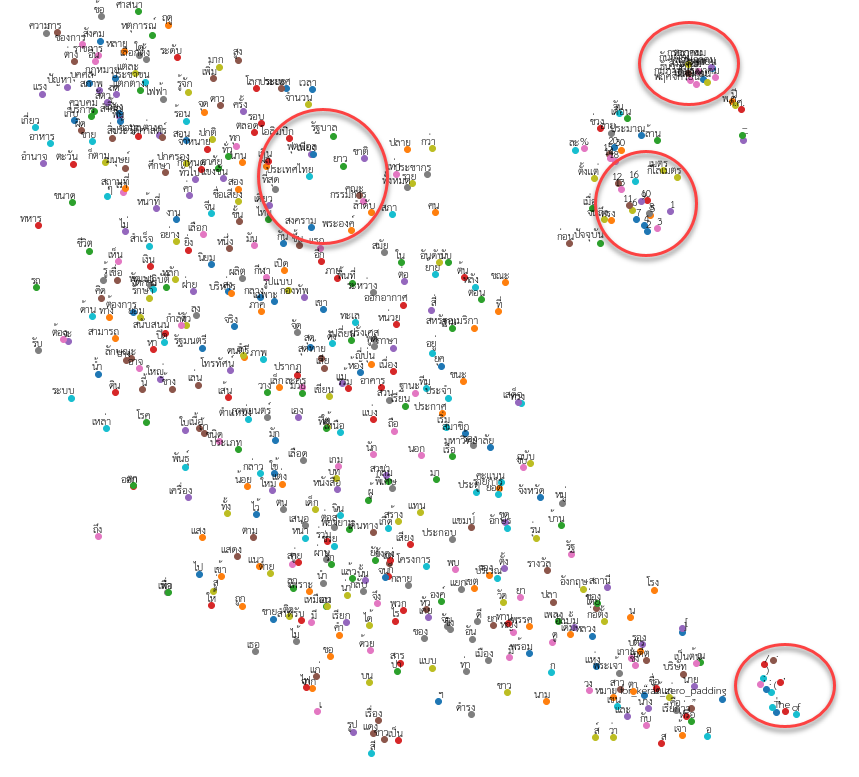

In [46]:
# Step 5: Visualize the embeddings.
# Function to draw visualization of distance between embeddings.
#reference: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
def plot_with_labels(low_dim_embs, labels, filename="tsne_plot.png"):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))  # in inches
    plt.axis('off')
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
 
    plt.show()
    plt.savefig(filename)

In [47]:
import matplotlib
import matplotlib.font_manager as fm

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')

--2021-02-20 08:06:38--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-02-20 08:06:38--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.2’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.02s   

2021-02-20 08:06:38 (5.43 MB/s) - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  """


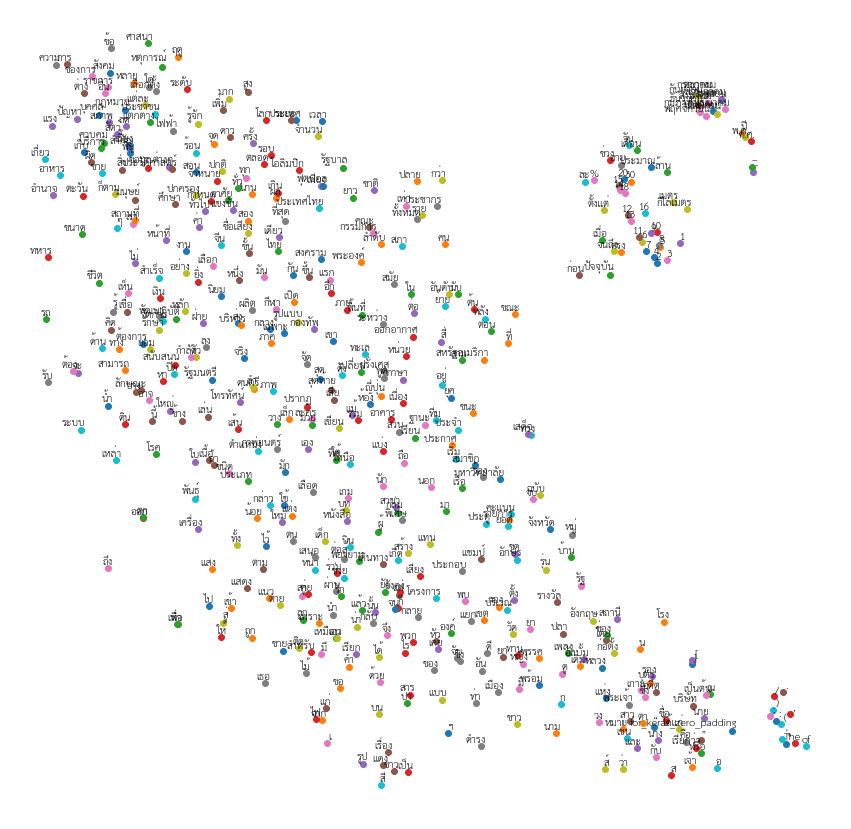

<Figure size 432x288 with 0 Axes>

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [49]:
#a:b     ::   c:semantic_analogy
import scipy

def semantic_analogy(a,b,c,final_embeddings,top = 20):
  n = final_embeddings[dictionary[a]] - final_embeddings[dictionary[b]] + final_embeddings[dictionary[c]]
  v = n.reshape(1, -1)
  all_dist = scipy.spatial.distance.cdist(final_embeddings, v, 'cosine').reshape(-1)
  idx =np.argpartition(all_dist, top)[:top]
  #sort
  idx = idx[np.argsort(all_dist[idx[:top]])]
  print('(' + a + ' : ' + b + ')   ::   (' + c + ' : ??)')
  for i in idx:
      print(reverse_dictionary[i])

In [50]:
#1

semantic_analogy('ตุลาคม','กันยายน','พฤศจิกายน',final_embeddings,10)

(ตุลาคม : กันยายน)   ::   (พฤศจิกายน : ??)
พฤศจิกายน
ตุลาคม
พฤษภาคม
มีนาคม
มกราคม
เมษายน
กรกฎาคม
มิถุนายน
สิงหาคม
กุมภาพันธ์


In [51]:
#2

semantic_analogy('ตุลาคม','กันยายน','สิงหาคม',final_embeddings,10)

(ตุลาคม : กันยายน)   ::   (สิงหาคม : ??)
สิงหาคม
ตุลาคม
มีนาคม
เมษายน
มกราคม
กุมภาพันธ์
มิถุนายน
กรกฎาคม
พฤษภาคม
พฤศจิกายน


In [52]:
#3

semantic_analogy('ตุลาคม','กันยายน','มกราคม',final_embeddings,10)

(ตุลาคม : กันยายน)   ::   (มกราคม : ??)
มกราคม
พฤษภาคม
มีนาคม
ตุลาคม
มิถุนายน
เมษายน
สิงหาคม
กรกฎาคม
พฤศจิกายน
ธันวาคม


In [53]:
#4

semantic_analogy('ตุลาคม','กันยายน','มีนาคม',final_embeddings,10)

(ตุลาคม : กันยายน)   ::   (มีนาคม : ??)
มีนาคม
พฤษภาคม
มิถุนายน
เมษายน
ตุลาคม
มกราคม
สิงหาคม
กรกฎาคม
พฤศจิกายน
กุมภาพันธ์


In [54]:
#5

semantic_analogy('นาย','ชาย','นาง',final_embeddings,10)

(นาย : ชาย)   ::   (นาง : ??)
เรี่ยราด
นาย
หลักทักษา
พระลามะ
Meltyukhov
56mm
ส้มเหลือ
พระธรรมธีรราชมหามุนี
ย์ทวี
Revelations


In [55]:
#6

semantic_analogy('พระราชา','ชาย','พระราชินี',final_embeddings,10)

(พระราชา : ชาย)   ::   (พระราชินี : ??)
แมนดาลอเรี่ยน
รอมิดา
1765
สะดวก
ตำบลดอน
ลาฮุดดีน
9000
หอบหืด
เปนเซอร์
ทรงกิตรัตน์


In [56]:
#7

semantic_analogy('พ.ศ.','2554','ค.ศ.',final_embeddings,10)

(พ.ศ. : 2554)   ::   (ค.ศ. : ??)
(ค.ศ.
ค.ศ.
(พ.ศ.
พ.ศ.
ปี
–
-
มีนาคม
มิถุนายน
เมษายน


In [57]:
#8

semantic_analogy('วัน','เสาร์','เดือน',final_embeddings,10)

(วัน : เสาร์)   ::   (เดือน : ??)
กรกฎาคม
สิงหาคม
กุมภาพันธ์
ธันวาคม
พฤษภาคม
เมษายน
มีนาคม
ตุลาคม
มกราคม
มิถุนายน


In [58]:
#8

semantic_analogy('ประเทศญี่ปุ่น','ญี่ปุ่น','ประเทศไทย',final_embeddings,10)

(ประเทศญี่ปุ่น : ญี่ปุ่น)   ::   (ประเทศไทย : ??)
2275
ประเทศญี่ปุ่น
650
1636
ประเทศไทย
เกี่ยวพัน
1933
น็อค
1954
เข้าศึกษา


In [59]:
#9

semantic_analogy('ยุโรป','ฝรั่งเศส','เอเชีย',final_embeddings,10)

(ยุโรป : ฝรั่งเศส)   ::   (เอเชีย : ??)
มุซุ
เอเชีย
คดีวอเตอร์เกต
นิสิต
ลาลีกา
อสุจิ
สมเด็จพระมหาธรรมราชา
จังหวัดสมุทรสาคร
วุฒิสภา
ตำแหน่งประธานาธิบดี


In [60]:
#10

semantic_analogy('สูง','ต่ำ','ใกล้',final_embeddings,10)

(สูง : ต่ำ)   ::   (ใกล้ : ??)
ใด
ช้าง
รีโมต
มนุษย์
ฟลายเวท
เต้นรำ
ฃ
เท็ดดี้
ราษฎร
โอริกอน


# Step 6: Extrinsic Evaluation

## <font color='blue'>Homework Question5:</font>
<font color='blue'>
Use the word embeddings from the skip-gram model as pre-trained weights in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


<font color='red'>Q5: From the code below, I find out that accuray is improved by 1% from 49% in w/o pretrain wt. to 50% in w/ pretrain wt.</font>

In [31]:
all_news_filepath = glob.glob('BEST-TrainingSet/news/*.txt')
all_novel_filepath = glob.glob('BEST-TrainingSet/novel/*.txt')
all_article_filepath = glob.glob('BEST-TrainingSet/article/*.txt')
all_encyclopedia_filepath = glob.glob('BEST-TrainingSet/encyclopedia/*.txt')

In [32]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)

val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [42]:
#the classification model
#TODO#5 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True))
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2000, 32)          9445280   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 9,451,748
Trainable params: 9,451,748
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/10 [==============================] - 16s 1s/step - loss: 1.3774 - accuracy: 0.3111 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 1.2546 - accu

In [43]:
results = cls_model.evaluate(test_input, test_target)
print("test loss, test acc:", results)

4/4 [==============================] - 2s 144ms/step - loss: 2.7981 - accuracy: 0.4902
test loss, test acc: [2.798137664794922, 0.4901960790157318]


In [33]:
## Pretrain Weight

In [38]:
SkipGram.load_weights('my_skipgram32_weights-hw.h5')

# final_embeddings = SkipGram.get_layer('embedding').get_weights()
final_embeddings = SkipGram.get_layer('embedding').get_weights()
# final_embeddings = SkipGram.get_weights()
len(final_embeddings[0])

295165

In [35]:
len(SkipGram.get_weights()[0][0])

32

In [39]:
cls_model_pt = Sequential()
cls_model_pt.add(Embedding(len(dictionary)+1, 32, weights=final_embeddings, input_length=max_length,mask_zero=True))
cls_model_pt.add(GRU(32))
cls_model_pt.add(Dropout(0.5))
cls_model_pt.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model_pt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model_pt.summary()

# cls_model_pt.load_weights('my_skipgram32_weights-hw.h5')

print('Train...')
cls_model_pt.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2000, 32)          9445280   
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 9,451,748
Trainable params: 9,451,748
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/10 [==============================] - 16s 1s/step - loss: 1.4440 - accuracy: 0.2900 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 1.3181 - accu

In [40]:
results_pt = cls_model_pt.evaluate(test_input, test_target)
print("test loss, test acc:", results_pt)

4/4 [==============================] - 2s 147ms/step - loss: 1.8710 - accuracy: 0.5000
test loss, test acc: [1.8710047006607056, 0.5]


In [44]:
## Compare with_pretrain and wo_pretrain

print("W/O Pretrain test loss, test acc:", results)
print("W/ Pretrain  test loss, test acc:", results_pt)
print("(W/ Pretrain - W/O Pretrain)  test loss:", results_pt[0]-results[0])
print("(W/ Pretrain - W/O Pretrain)  test acc:", results_pt[1]-results[1])

## % accuracy improve by 19% from 54% to 73%

W/O Pretrain test loss, test acc: [2.798137664794922, 0.4901960790157318]
W/ Pretrain  test loss, test acc: [1.8710047006607056, 0.5]
(W/ Pretrain - W/O Pretrain)  test loss: -0.9271329641342163
(W/ Pretrain - W/O Pretrain)  test acc: 0.009803920984268188
